## Facial Expression Recognition with Tensorflow

In this project, we will explore a Kaggle competition that was posted several years ago. The challenge was to take a training set of face images, apply machine learning, and be able to predict the emotions in a set of test images. Each image is categorized under one emotion, which are as follows:

0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral

We will build a model in Tensorflow and evaluate how that model performed.

Data source here:
https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data

In [1]:
#importing libraries for exploring dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from matplotlib.image import imread

In [2]:
#reading in the csv file
images = pd.read_csv('icml_face_data.csv.zip')

In [3]:
#checking out the dataframe
images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1    Usage   35887 non-null  object
 2    pixels  35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


Each row in the dataset contains whether it is part of the training or test set (Usage), the emotion category (emotion), and the pixels (pixels) corresponding to the actual image data. 

Before we look at the actual data, it looks like we have some spaces in the column names. Let's strip those out.

In [4]:
#stripping whitespace from the column names
images.columns = images.columns.str.strip()

#rechecking the dataframe
images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   Usage    35887 non-null  object
 2   pixels   35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


First, let's view one of the pictures to get a sense of what the data looks like.

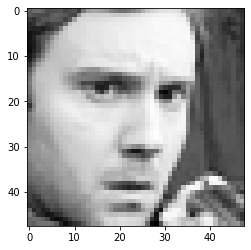

In [5]:
#extracting the first picture in the csv file
pic1 = images.loc[0,'pixels']

#splitting the pixels up, converting the pixels from strings to integers, and reshaping
#into a 48x48 shape
pic_strip = pic1.split(' ')
pic_strip = [int(num) for num in pic_strip]
final_pic = np.reshape(pic_strip,(48,48))

#showing the picture, which is in greyscale
plt.imshow(final_pic, cmap='Greys_r')
plt.show()

We have the picture. What emotion is this classified as in the dataset?

In [6]:
images.loc[0,'emotion']

0

0 is the code for Angry. 

Now that we have an example of what the images look like, let's convert all the images into their own files. Then we'll save these files in their own respective folders. This will be used later when we begin preparing the images for the neural network. We'll also split up the images into training, validation, and test sets.

In [7]:
#defined folder for pictures to go into
path = '/Facial Recognition/'

#function to reshape each row of pixels into an image
def create_images(pic, n):
    pic_info = pic.loc[n,'pixels'].split(' ')
    pic_info = [int(num) for num in pic_info]
    final_pic = np.reshape(pic_info,(48,48))
    return final_pic

#splitting the images dataframe into a training set and a test set
training = images.loc[images.Usage=='Training',:]
testing = images.loc[images.Usage=='PublicTest',:]

#creating a validation set from the training set
val_len = round(0.25 * training.shape[0])
validation = training.iloc[(training.shape[0]-val_len):,:]

#reshaping the training set
training = training.iloc[:(training.shape[0]-val_len),:]

#write each set of pixels into its own image in a designated folder
em_map_str= {0:'Angry',1:'Disgust',2:'Fear',3:'Happy',4:'Sad',5:'Surprise',6:'Neutral'}

for file_dir in ['Train','Test','Validation']:

    if file_dir == 'Train':
        df = training
    elif file_dir == 'Test':
        df = testing
    else:
        df = validation
    
    for sub_dir in images.emotion.unique():
        [cv2.imwrite(path+file_dir+'/'+em_map_str[sub_dir]+'/face_'+str(i)+'.jpg', 
                     create_images(images,i)) for i in df.loc[df.emotion==sub_dir,:].index]

print('Number of training images:',training.shape[0])
print('Number of validation images:',validation.shape[0])
print('Number of test images:',testing.shape[0])

Number of training images: 21532
Number of validation images: 7177
Number of test images: 3589


Now that we've separated the data into a training, validation, and test set, let's take a look at the classes in the training set.

In [8]:
training.emotion.value_counts()

3    5417
6    3718
4    3606
2    3124
0    3009
5    2314
1     344
Name: emotion, dtype: int64

Based on the counts above, the classes are imbalanced. The top emotion (Happy) occurs 5,417 times, but the least present emotion (Disgust) only occurs 344 times. We will need to either 1) upsample the least present class or 2) assign weights the classes so the model trains correctly.

We'll use weights, which we will define later below. For now we will build our model.

In [9]:
#importing Tensorflow libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization

In [10]:
#instantiating the neural network
model = Sequential()

We've instantiated an object of the Sequential class, which creates the base of the neural network. Next, we will add layers into the network. The first set of layers will be our feature detection layers, designed to determine what the relevant features in each image are, and extract them. This is done using convolution and max pooling. 

Convolution takes a matrix and slides it over the image to convolve the two together. This is  filtering the image to extract relevant features, creating a set of feature matrices. Each feature matrix shows a specific feature from the image. 

We follow covolution by max pooling. This takes a smaller matrix (in this case we will use a 2x2), slides it over the image, and retains the maximum value of the pixels in each window. This further defines relevant features while filtering out excess information. These steps create a set of feature detection matrices. 

The feature detection matrices are fed into the network after being flattened, as the input into the neural network must be a 1D vector.

In [11]:
#Adding 4 sets of convolutional/pooling layers

#Convolution - creating 32 filters of size 3x3, using ReLu activation function
model.add(Conv2D(filters=32,kernel_size=3,input_shape=(48,48,1),activation='relu'))
#Batch normalization layer
model.add(BatchNormalization())
#max pooling layer, with 2x2 size
model.add(MaxPool2D(pool_size=(2,2)))

#adding additional layers
model.add(Conv2D(filters=64,kernel_size=3,activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=128,kernel_size=3,activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=128,kernel_size=3,activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))

#Flattening input into 1D vector
model.add(Flatten())

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 46, 46, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 21, 21, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         7

We've completed the input layer of the network. Next we create fully hidden layers and the output layer, which will give us our classification. The output layer will have 7 nodes since this classification problem has 7 possible outputs. 

In [12]:
#adding fully connected inner layer
model.add(Dense(128, activation='relu')) 

#adding another fully connected inner layer
model.add(Dense(128, activation='relu')) 

#adding the output layer
model.add(Dense(7, activation='softmax'))

Next we will compile the model and fit the model to the training data. 

In [13]:
#compile the model
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

Before we run the model, we will normalize all the pixels between the values 0 and 1. We will also perform image augmentation with the ImageDataGenerator class in Tensorflow. This class performs rotating, shearing, shifting, etc on images and generates new ones, essentially "creating" new images to train from. This will compensate to a degree for the lack of images available in the dataset.

Here we also define the weights to be used during training. Because we have at least 1 class that is underrepresented, that class will be weighted more heavily than the others. This should help address the imbalance problem.

In [14]:
#import libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from collections import Counter

#setting batch size
batch_size=64
training_size = training.shape[0]
validation_size = validation.shape[0]

#creating an ImageDataGenerator object for the training set for augmentation
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=15,
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        horizontal_flip=True,fill_mode='nearest')

#creating a separate ImageDataGenerator object for the validation set
test_datagen = ImageDataGenerator(rescale=1./255)

path_train = '/Facial Recognition/Train'
path_val = '/Facial Recognition/Validation'

#creating "new" images according to batch size
train_generator = train_datagen.flow_from_directory(
        path_train,
        target_size=(48, 48),
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='grayscale',
        seed=1, shuffle=True)

validation_generator = train_datagen.flow_from_directory(
        path_val,
        target_size=(48, 48),
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='grayscale',
        seed=1, shuffle=True)

#defining early stopping and learning rate callbacks for model fitting
ES = EarlyStopping(monitor='val_loss',patience=5)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3,min_delta=0.0001)

#computing class weights and placing them in a dictionary
counter = Counter(train_generator.classes)    
max_num = max(counter.values()) 
weights = {class_id : max_num/num for class_id, num in counter.items()} 

#fitting the model
model.fit(
        train_generator,
        steps_per_epoch=training_size//batch_size,
        epochs=50,
        validation_data=validation_generator, shuffle=True,callbacks=[ES,reduce_lr],
        class_weight=weights,
        validation_steps=validation_size//batch_size)

Found 21532 images belonging to 7 classes.
Found 7177 images belonging to 7 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 336 steps, validate for 112 steps
Epoch 1/50
336/336 [==============================] - 153s 456ms/step - loss: 3.3794 - accuracy: 0.2025 - val_loss: 3.4596 - val_accuracy: 0.1738
Epoch 2/50
336/336 [==============================] - 73s 218ms/step - loss: 3.1997 - accuracy: 0.2557 - val_loss: 3.0691 - val_accuracy: 0.3022
Epoch 3/50
336/336 [==============================] - 58s 172ms/step - loss: 3.0494 - accuracy: 0.3096 - val_loss: 3.4797 - val_accuracy: 0.3114
Epoch 4/50
336/336 [==============================] - 58s 172ms/step - loss: 2.9268 - accuracy: 0.3472 - val_loss: 3.2992 - val_accuracy: 0.3013
Epoch 5/50
336/336 [==============================] - 56s 167ms/step - loss: 2.8264 - accuracy: 0.3793 - val_loss: 2.8415 - val_accuracy: 0.3585
Epoch 6/50
336/336 [==============================] - 57s 168ms/step - loss: 2.7515 - accuracy:

We've completed our first run of this model. On first glance, the validation accuracy is much better than if we were picking a class for each picture at random (which would be 14%). Still, there is room for improvement.

The model has been trained, so let's examine how the model performed and get predictions. We'll start by plotting out the losses and accuracy during training.

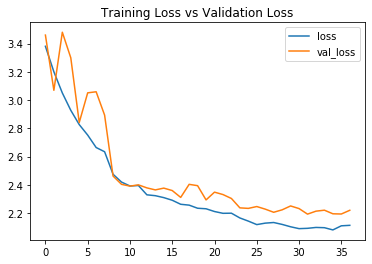

In [15]:
losses = pd.DataFrame(model.history.history)
losses.loc[:,['loss','val_loss']].plot()
plt.title('Training Loss vs Validation Loss')
plt.show()

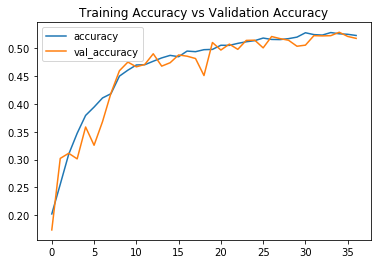

In [16]:
losses.loc[:,['accuracy','val_accuracy']].plot()
plt.title('Training Accuracy vs Validation Accuracy')
plt.show()

We can tell from the above graphs when the training ended, because the loss and accuracy started to level off. We can also see that because accuracy is the around same for both training and validation, that the model did not overfit to the training set. This is good because it indicates the model can take new data and make accurate predictions.

Next we will analyze the predictions.

In [17]:
path_test = '/Facial Recognition/Test'

#create test image datagenerator
test_generator = test_datagen.flow_from_directory(
        path_test,
        target_size=(48, 48),
        batch_size=32,
        class_mode='categorical',
        color_mode='grayscale',
        seed=1)

#getting predictions using test image generator
pred=model.predict(x=test_generator)

#getting the predicted class indices
predicted_class_indices=np.argmax(pred,axis=1)

Found 3589 images belonging to 7 classes.


In [18]:
#getting the labels
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())

#matching the labels to the class indices
predictions = [labels[k] for k in predicted_class_indices]

In [19]:
#mapping the labels to their numerical classifications for the classification report
em_map_num={'Angry':0,'Disgust':1,'Fear':2,'Happy':3,'Sad':4,'Surprise':5,'Neutral':6}
predictions_num = [em_map_num[i] for i in predictions]

In [20]:
#import metrics from scikit learn 
from sklearn.metrics import classification_report

#print the classification report
print(classification_report(test_generator.classes,predictions_num))

              precision    recall  f1-score   support

           0       0.14      0.15      0.14       467
           1       0.02      0.07      0.03        56
           2       0.15      0.11      0.12       496
           3       0.26      0.22      0.24       895
           4       0.18      0.12      0.14       607
           5       0.17      0.15      0.16       653
           6       0.11      0.21      0.15       415

    accuracy                           0.16      3589
   macro avg       0.15      0.15      0.14      3589
weighted avg       0.18      0.16      0.17      3589



Based on the above classification report, the classes that were best categorized by this model were 3 (Happy) and 5 (Surprise), with the worst being 1 (Disgust). The fact that disgust was not classified well is not a surpise, as it had the least amount of data available. However, we used class weighting to try and compensate for this.

This concludes our first run of this tensorflow model. Although our final validation accuracy hit 52% (which is better than if we picked a class for each picture at random), there is still room for improvement. To make our accuracy higher, we could experiment with adding hidden layers and dropping neurons. But one of the most important things we could do is to add more data, as the amount of images we have for classification is quite small. This includes increasing the number of minority class images to make the dataset less imbalanced.